Getting Started
===============

Setup
-----


In [1]:
import matplotlib.pyplot as plt
plt.style.use('lightning.plots.style.lightning-serif')

The primary interface to ``lightning.py`` (hereafter, just ``lightning``) is the ``Lightning`` class.

In [1]:
from lightning import Lightning

This class holds all the information about the models and observations that are needed to perform inference
with your chosen models. In its most basic configuration for inference, ``Lightning`` requires you to specify
a set of bandpasses, a distance indicator (either a distance in Mpc or a redshift), and fluxes and uncertainties
corresponding to those bandpasses (in mJy).

In [2]:
import numpy as np
filter_labels = ['SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z']
dist = 7.2
fnu = np.array([237.147, 606.260, 929.869, 1205.353, 1337.25])
fnu_unc = np.array([24.045, 61.632, 94.810, 122.585, 135.481])
lgh = Lightning(filter_labels, lum_dist=dist, flux_obs=fnu, flux_obs_unc=fnu_unc)

Note that ``filter_labels`` is the first and only positional argument, since it's the only argument that's always required:
we could specify redshift rather than distance, and it's possible to not specify fluxes and uncertainties (e.g., if
you're simulating fluxes). Note also that the ``flux_obs`` and ``flux_unc`` keywords should be set by numpy arrays.

The setup here will adopt the defaults: 5 age bins spaced from 0.0-13.4 Gyr, modified Calzetti extinction (as in Noll+2009)
and no dust emission (or AGN emission). All of these choices can be modified or made explicit by setting the appropriate
keywords when initializing ``Lightning``.

We can print the full set of model parameters with

In [3]:
lgh.print_params()

['psi_1', 'psi_2', 'psi_3', 'psi_4', 'psi_5']
['Zmet']
['mcalz_tauV_diff', 'mcalz_delta', 'mcalz_tauV_BC']

Total parameters: 9


The ``verbose`` option to ``print_params`` additionally describes the parameters and gives their allowed ranges.


Inference
---------

The last step before we can perform Bayesian inference is to define priors for each parameter. In ``lightning``
priors are passed to the ``fit`` method as a list of objects from the ``lightning.priors`` module.

In [4]:
from lightning.priors import UniformPrior, ConstantPrior
priors = [UniformPrior([0,10]),
          UniformPrior([0,10]),
          UniformPrior([0,10]),
          UniformPrior([0,10]),
          UniformPrior([0,10]),
          ConstantPrior([0.020]),
          UniformPrior([0,3]),
          ConstantPrior([0.0]),
          ConstantPrior([0.0])]

Note that the priors are (and must be) in the same order as the parameter list produced by ``lgh.print_params``: the first 5 correspond
to the SFH coefficients, the next is the stellar metallicity, and the final three are the parameters of the attenuation
curve.

To fit with ``emcee`` we must define an initial state. We can sample this state from the priors of the model:

In [5]:
Nwalkers = 32
const_dim = np.array([pr.model_name == 'constant' for pr in priors])
p0 = np.stack([pr.sample(Nwalkers) for pr in priors], axis=-1)
print(p0.shape)

(32, 9)


In [6]:
mcmc = lgh.fit(p0,
               method='emcee',
               priors=priors,
               const_dim=const_dim,
               Nwalkers=Nwalkers,
               Nsteps=10000,
               progress=True)

/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:449: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 288.13it/s]


The ``const_dim`` keyword is a holdover from previous versions predating ``ConstantPrior``. When the MCMC sampling has
finished, we can construct the final MCMC chain with the ```get_mcmc_chains``` method:

In [8]:
chain, logprob_chain, tau = lgh.get_mcmc_chains(mcmc,
                                                discard=3000,
                                                thin=500,
                                                Nsamples=300,
                                                const_dim=const_dim,
                                                const_vals=p0[0,const_dim])

         The autocorrelation estimate may be unreliable.


The above command can be read as "discard the first 3000 samples from each walker, retain only every 500th sample after
that, and then return the last 1000 samples after merging the separate chains from each walker." The ``const_dim`` and
``const_vals`` keywords allow us to add back in the constant dimensions of the model (since they aren't sampled, the
``mcmc`` sampler object returned by ``emcee`` doesn't know anything about them) such that the ``chain`` array has shape
(1000, 9). The ``tau`` returned by the above command is the estimate of the integrated autocorrelation time for
each parameter. If the chains were run too short, the estimate may be unreliable (or not available). In that case the MCMC
sampling can be continued from its stopping point with ``mcmc.run_mcmc(Nsteps)`` and then the above command can be run
again to construct the chains. In practice the discard and thin factors can be chosen based on the autocorrelation time
(~a few times and ~0.5-1 times, are decent choices, respectively), but arbitrarily chosen scales are often fine as long
as one inspects the chains for correlated behavior. That can be done with a chain plot:

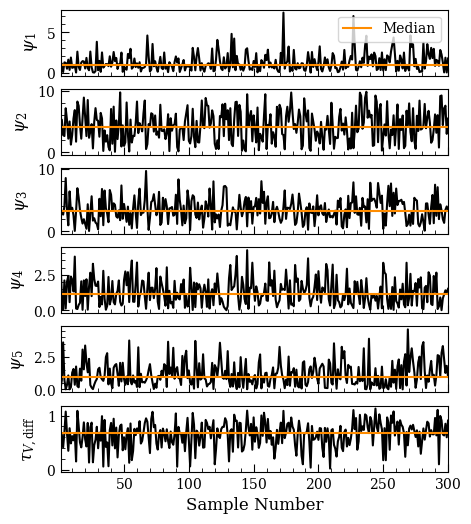

In [9]:
fig, ax = lgh.chain_plot(chain)

/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:449: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


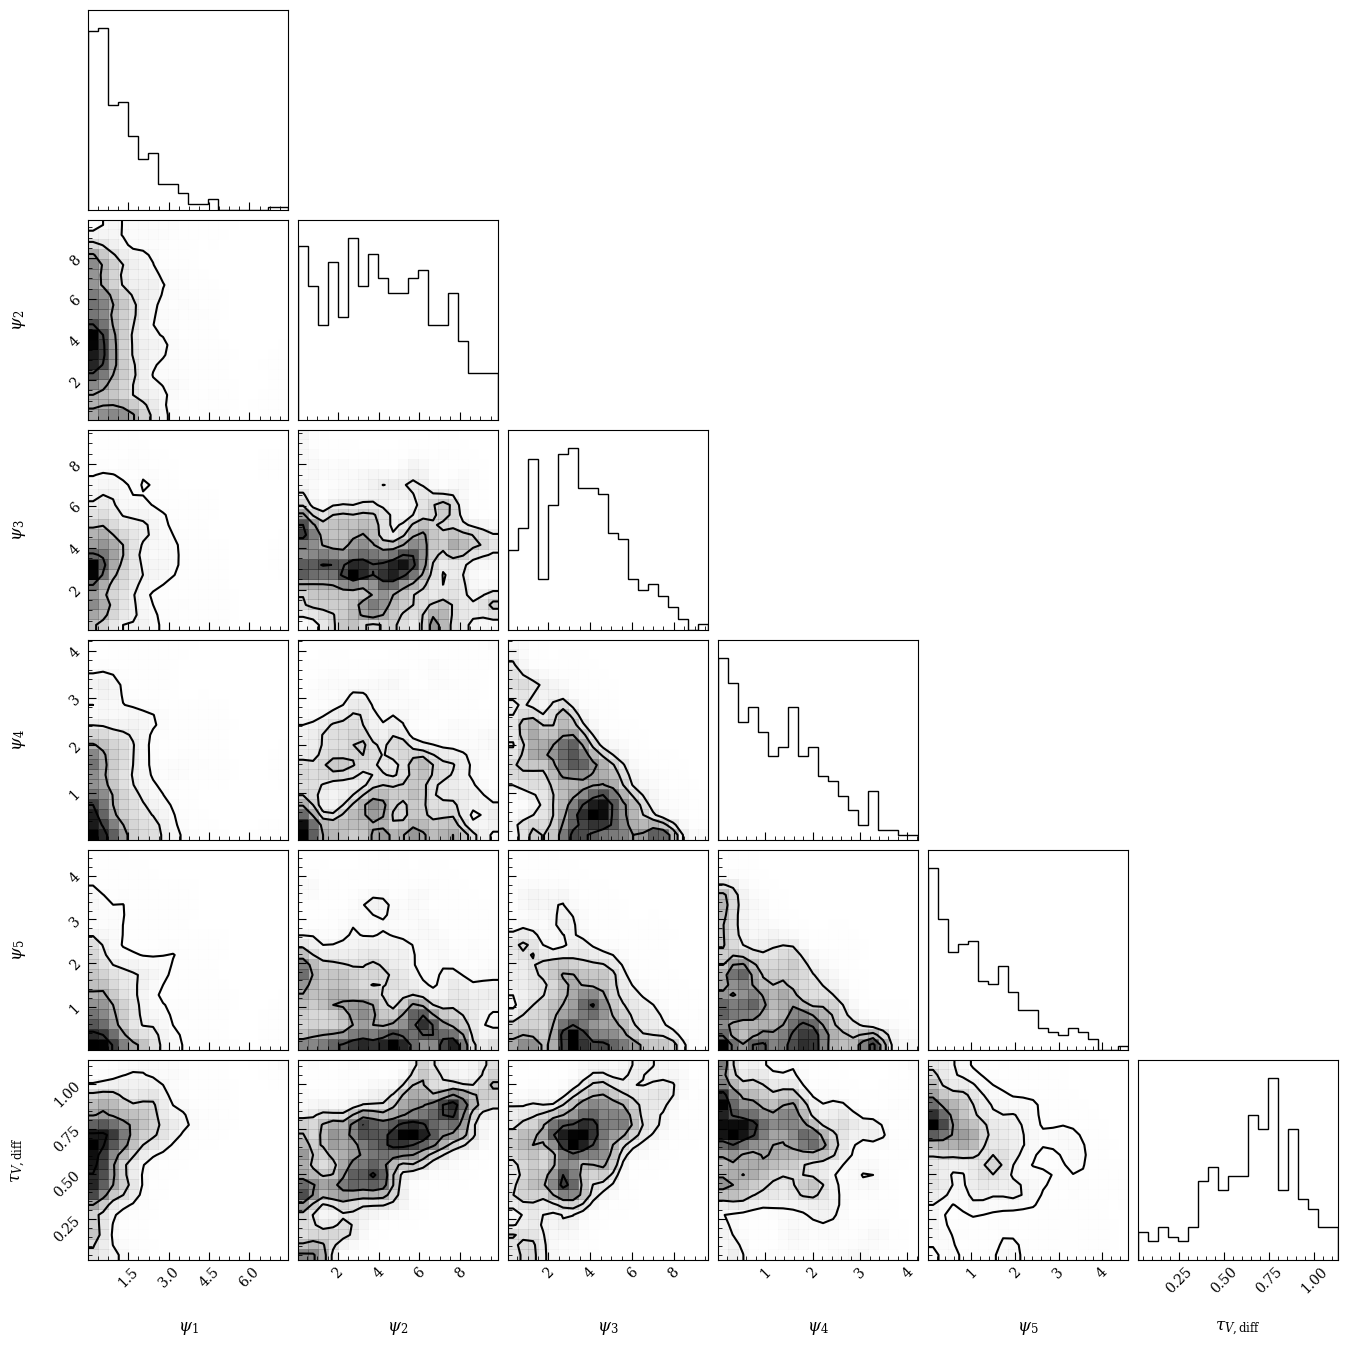

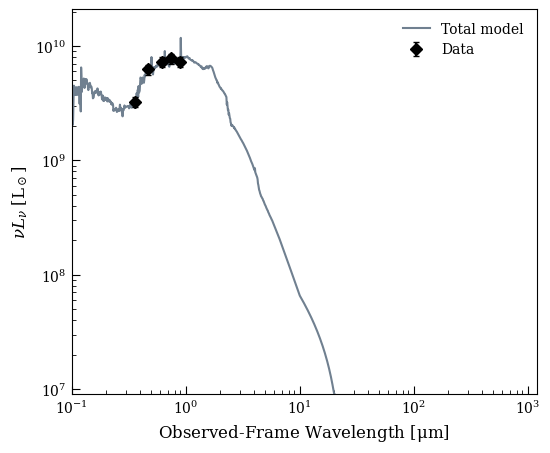

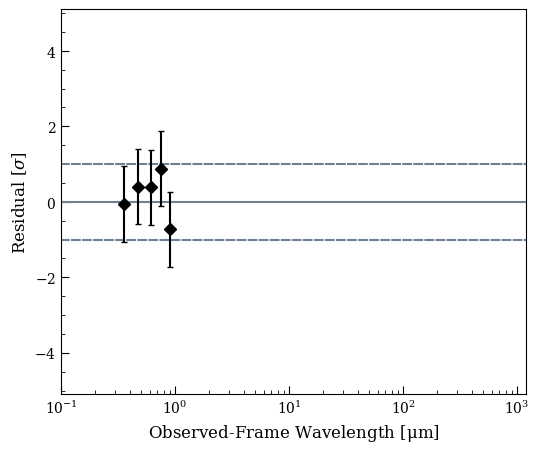

In [12]:
fig1 = lgh.corner_plot(chain, titles=True, smooth=1)
fig2, ax2 = lgh.sed_plot_bestfit(chain, logprob_chain)
fig3, ax3 = lgh.sed_plot_delchi(chain, logprob_chain)

It's worth here considering how well the model can reproduce the observed data. The built in methods for goodness of fit
are based on the posterior predictive check, which samples sets of parameters from the chain, uses them to generate a
new dataset with the same noise characteristics as the original dataset, and compares this new dataset to the model. The
fraction of new datasets that have worse $\chi^2$ than the fit to the observed model is the $p-$value.

In [15]:
from lightning.ppc import ppc, ppc_sed
pvalue, chi2_rep, chi2_obs = ppc(lgh, chain, logprob_chain)
print('p = %.2f' % pvalue)

p = 0.60


There is also the option to make an SED plot showing the range of data that can be produced by the model:

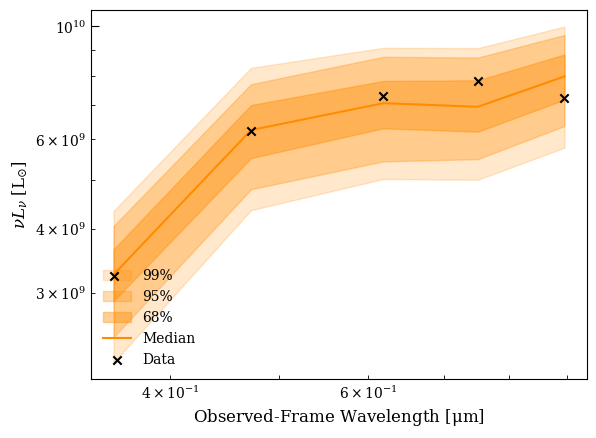

In [16]:
fig, ax = ppc_sed(lgh, chain, logprob_chain)

All of our data are very well reproduced by the model, yielding a $p-$value of 0.60.